In [28]:
import pandas as pd
import os
import plotly.express as px
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.model_selection import GridSearchCV

In [29]:

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict
    
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def display_large(df):
    """Displays up to 1000 columns and rows of pandas.DataFrame or pandas.Series objects."""
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

def rf_feature_importance(fitted_model, df):
    "Creates a pandas.Dataframe of a Random Forest's feature importance per column."
    return pd.DataFrame(
        {"Column": df.columns, "Importance": fitted_model.feature_importances_}
    ).sort_values("Importance", ascending=False)

def plot_feature_importance(feature_importance):
    fig, ax = plt.subplots(figsize=(12,8))
    return sns.barplot(y="Column", x="Importance", data=feature_importance, color="b")


In [30]:
file : str          = os.path.join(os.getcwd(), "data","merged.csv")
df : object         = pd.read_csv(file)

In [31]:
df.dtypes

LEFT_ANKLE_x     float64
LEFT_ANKLE_y     float64
LEFT_ANKLE_z     float64
LEFT_ANKLE_v     float64
LEFT_EAR_x       float64
                  ...   
RIGHT_WRIST_y    float64
RIGHT_WRIST_z    float64
RIGHT_WRIST_v    float64
image_name        object
label              int64
Length: 126, dtype: object

In [32]:
df  = df.drop(columns=['image_name'])
df =  df.dropna()
df["label"] = df["label"].astype("category")
df.replace(to_replace= 1, value = 0, inplace=True )
print(df["label"].unique())

[0, 2]
Categories (2, int64): [0, 2]


In [33]:
X, y, nas = proc_df(df, "label")

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"{len(X_train)} train rows + {len(X_valid)} valid rows")

140 train rows + 36 valid rows


In [35]:
#model tuning parameters
n_estimators : list     = [5, 8, 13, 21, 34, 55, 89]
max_depth : list        = [5, 8, 13, 21, 34, 55, 89]
max_leafes : list       = [5, 8, 13, 21, 34, 55, 89]

In [36]:
def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
    }
    if hasattr(fitted_model, "oob_score_"):
        res["OOB accuracy:"] = fitted_model.oob_score_

    for k, v in res.items():
        print(k, round(v, 3))

In [37]:
model = rfc(n_estimators=10, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [38]:
print_scores(model)

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.861
ROC AUC on valid: 0.978


C:\Users\kobim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


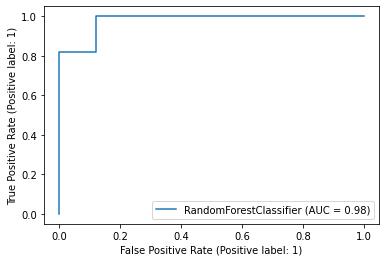

In [39]:
plot_roc_curve(model, X_valid, y_valid)
plt.show()

C:\Users\kobim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


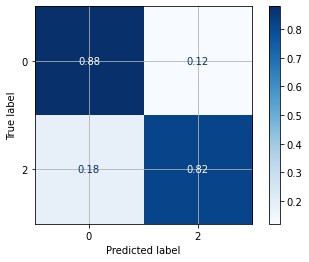

In [40]:
# extract labels for classes
class_names = df["label"].cat.categories

plot_confusion_matrix(
    model,
    X_valid,
    y_valid,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize="true",
)
plt.grid(None)

In [41]:
# define range of values for each hyperparameter
param_grid = [
    {
        "n_estimators": [10, 20, 40, 80, 100],
        "max_features": [0.5, 1.0, "sqrt", "log2"],
        "min_samples_leaf": [1, 3, 5, 10, 25],
    }
]

# instantiate baseline model
model = rfc(n_estimators=10, n_jobs=-1, random_state=42)

# initialise grid search with cross-validation
grid_search = GridSearchCV(
    model, param_grid=param_grid, cv=3, scoring="roc_auc", n_jobs=-1     # 3-fold cross-validation
)

In [42]:
%time grid_search.fit(X, y)

Wall time: 5.62 s


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=10, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid=[{'max_features': [0.5, 1.0, 'sqrt', 'log2'],
                          'min_samples_leaf': [1, 3, 5, 10, 25],
                          'n_estimators': [10, 20, 40, 80, 100]}],
             scoring='roc_auc')

In [43]:
best_params = grid_search.best_params_
best_params

{'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 20}

In [44]:
best_model = grid_search.best_estimator_
best_model

RandomForestClassifier(max_features=0.5, n_estimators=20, n_jobs=-1,
                       random_state=42)

In [45]:
print_scores(best_model)

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 1.0
ROC AUC on valid: 1.0


C:\Users\kobim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


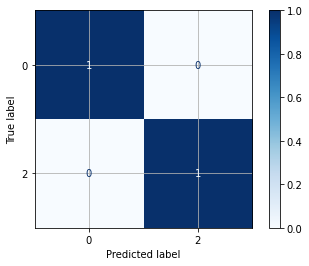

In [46]:
plot_confusion_matrix(
    best_model,
    X_valid,
    y_valid,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize="true",
)
plt.grid(None)

In [47]:
feature_importance = rf_feature_importance(best_model, X)

# peek at top 10
feature_importance[:10]

,Column,Importance
69,RIGHT_EAR_y,0.162767
6,LEFT_EAR_z,0.149221
49,LEFT_SHOULDER_y,0.092274
114,RIGHT_SHOULDER_z,0.087137
77,RIGHT_EYE_y,0.081555
113,RIGHT_SHOULDER_y,0.074022
5,LEFT_EAR_y,0.058027
70,RIGHT_EAR_z,0.053350
85,RIGHT_EYE_OUTER_y,0.030069
50,LEFT_SHOULDER_z,0.023739


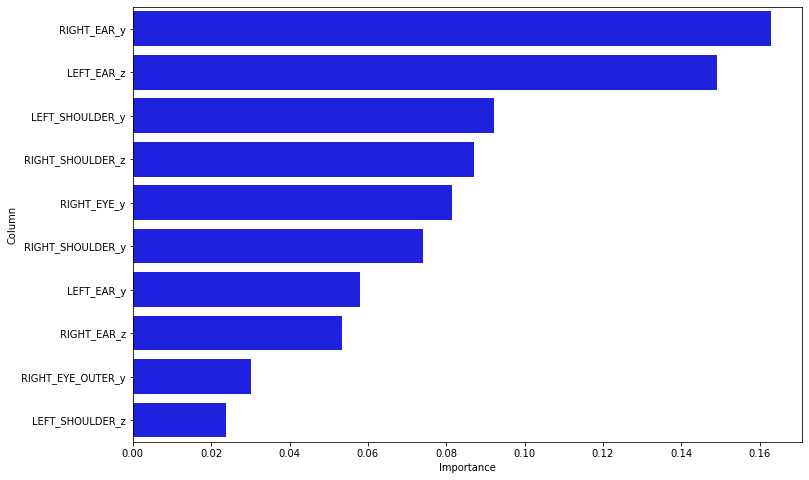

In [48]:
plot_feature_importance(feature_importance[:10])
plt.show()

In [49]:
df["label"].cat.categories

Int64Index([0, 2], dtype='int64')

In [50]:
def predict_live(x_live):
    prediction = best_model.predict(x_live)[0]
    return "lying" if prediction == 1 else "not lying"


In [51]:
predict_live(X_train[2:3])

'not lying'

In [52]:
#from pose_estimator import run_live

#run_live("data/video/4.mp4", classifier = best_model, record = True )

In [54]:
from joblib import dump, load

dump( best_model, "trained_classifier.joblib")


['trained_classifier.joblib']